In [170]:
import os, sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math

In [171]:
# to device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [172]:
# load data
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

H, W = images.shape[1:3]
# 100 test samples, RGB data
testimage, testpose = images[102], poses[102]
images = images[:100, ..., :3]
poses = poses[:100]
chunk = 1024

(100, 100, 3) (4, 4) 138.88887889922103


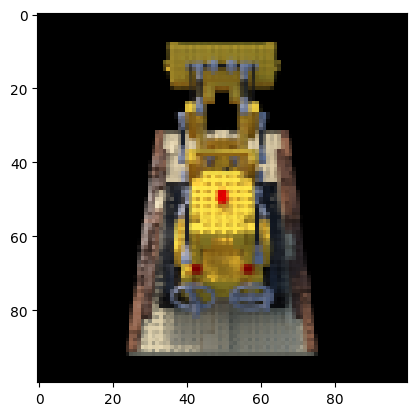

In [173]:
print(testimage.shape, testpose.shape, focal)
plt.imshow(testimage)

In [174]:
# from camera coordinate to world
def get_rays(H, W, focal, c2w):
    # hori: [0., 1.,..., W-1]
    hori_vector = torch.arange(0, W, dtype = torch.float32)
    # vert: [0., 1.,..., H-1]
    vert_vector = torch.arange(0, H, dtype = torch.float32)
    # hori_mesh: [0., 1.,..., W-1] * H layer, similar to vert_mesh
    hori_mesh, vert_mesh = torch.meshgrid(hori_vector, vert_vector, indexing='xy')
    # move to center
    hori_mesh = hori_mesh - (W-1)/2.
    vert_mesh = (vert_mesh - (H-1)/2.) * (-1)
    # normalize, use focal
    hori_mesh = hori_mesh / focal
    vert_mesh = vert_mesh / focal
    # stack, rays_dir.shape=[H, W, 3]
    z_mesh = torch.ones_like(hori_mesh) * (-1)
    rays_dir = torch.stack([hori_mesh, vert_mesh, z_mesh], -1)
    # to world space, c2w.shape = [4, 4]
    # Tensor与行向量做*乘法的结果是每列乘以行向量对应列的值
    # 向量不需要考虑平移
    # rays_dir.shape = rays_ori.shape = [H, W, 3]
    rays_dir = torch.sum(rays_dir[..., np.newaxis, :] * c2w[:3, :3], dim = -1)
    rays_ori = torch.broadcast_to(torch.tensor(c2w[:3,3]), rays_dir.shape)
    rays_dir.to(device)
    rays_ori.to(device)
    return rays_ori, rays_dir


In [175]:
def positional_encoding(x, l):
    # x.shape = [N, dimension]
    result = [x]
    for i in range(l):
        result.append(torch.sin(2.**i * math.pi * x))
        result.append(torch.cos(2.**i * math.pi * x))
    # output.shape = [1, dimension * 2 * l + dimension)]
    return torch.concat(result, -1)

In [176]:
# a simplified nerf model
class NeRF(nn.Module):
    def __init__(self, depth = 8, width = 256, encoding_l = 6):
        super().__init__()
        self.net1 = nn.Sequential()
        self.net2 = nn.Sequential()
        for i in range(depth // 2):
            if i == 0:
                self.net1.add_module(f'linear_{i}', nn.Linear(3 + 3 * 2 * encoding_l, width))
                self.net1.add_module(f'relu_{i}', nn.ReLU())
            else:
                self.net1.add_module(f'linear_{i}', nn.Linear(width, width))
                self.net1.add_module(f'relu_{i}', nn.ReLU())
        
        for i in range(depth // 2, depth):
            if i == depth // 2:
                self.net2.add_module(f'linear_{i}', nn.Linear(width + 3 + 3 * 2 * encoding_l, width))
                self.net2.add_module(f'relu_{i}', nn.ReLU())
            elif i == depth - 1:
                # here, no activation
                self.net2.add_module(f'linear_{i}', nn.Linear(width, 4))
            else:
                self.net2.add_module(f'linear_{i}', nn.Linear(width, width))
                self.net2.add_module(f'relu_{i}', nn.ReLU())
        
    def forward(self, x):
        # input is already encoded, shape = [N, dimension]
        output = self.net1(x)
        # output.shape = [N, width]
        output = self.net2(torch.concat([output, x], -1))
        # output.shape = [N, 4]
        # sigma->relu, rgb->sigmoid
        sigma_a = torch.relu(output[..., 3])
        rgb = torch.sigmoid(output[..., :3])
        return sigma_a, rgb

In [177]:
# near/far: true, physical frustum near/far plane in world coordicate
# rays_ori: camera origin position
# rays_dir: vector points from rays_ori to the z = -1 plane
# N_samples: sample number for each ray
# rand: if randomly select samples in a fixed range, or just simply uniformly sample
# render rays in one image
def render_rays(network, rays_ori, rays_dir, near, far, N_samples, rand = False):
    # predict batchly
    # def batchify_cal(model, inputs, chunk=1024*32):
    #     # if i + chunk >= input.shape[0], will automatically detect and truncate
    #     # return torch.concat([model(input[i: i + chunk]) 
    #     #                     for i in range(0, input.shape[0], chunk)], 0)
    #     sigma_a, rgb = model(inputs[:chunk])
    #     for i in range(chunk, inputs.shape[0], chunk):
    #         small_sigma_a, small_rgb = model(inputs[i: i + chunk])
    #         sigma_a = torch.concat([sigma_a, small_sigma_a], 0)
    #         rgb = torch.concat([rgb, small_rgb], 0)
    #     return sigma_a, rgb


    # compute z query values
    # rays_ori/rays_dir: [H, W, 3]
    # z_samples.shape = [H, W, N]
    if rand:
        z_samples = torch.linspace(near, far, N_samples + 1)
        # drop last one
        z_samples = z_samples[:-1]
        # unifomly, randomly sample in range like [near, near + (far-near)/(N)]
        z_samples = torch.broadcast_to(z_samples, list(rays_dir.shape[:2]) + [N_samples])
        z_samples = z_samples + torch.rand(z_samples.shape) * (far - near) / N_samples
    else:
        z_samples = torch.linspace(near, far, N_samples)
        z_samples = torch.broadcast_to(z_samples, list(rays_dir.shape[:2]) + [N_samples])

    z_samples.to(device)
    # compute 3D query point, target is points.shape = [H, W, N, 3]
    # points = [H, W, 1, 3] + [H, W, N, 1] * [H, W, 1, 3]
    points = rays_ori[..., np.newaxis, :] + z_samples[..., np.newaxis] * rays_dir[..., np.newaxis, :]
    points.to(device)
    flat_points = torch.reshape(points, [-1, 3])
    flat_points.to(device)
    # positional encoding
    inputs = positional_encoding(x = flat_points, l = 6)
    # predict
    inputs.to(device)
    # discard function, directly write here
    sigma_a, rgb = network(inputs[:chunk])
    for i in range(chunk, inputs.shape[0], chunk):
        small_sigma_a, small_rgb = network(inputs[i: i + chunk])
        sigma_a = torch.concat([sigma_a, small_sigma_a], 0)
        rgb = torch.concat([rgb, small_rgb], 0)

    # sigma_a, rgb = batchify_cal(network, inputs)
    sigma_a = torch.reshape(sigma_a, list(points.shape[:-1]))
    rgb = torch.reshape(rgb, points.shape)
    
    # volume rendering
    # z_subtract[H, W, m] = z_samples[H, W, m+1] - z_samples[H, W, m]
    z_subtract = z_samples[..., 1:] - z_samples[..., :-1]
    # inf_far.shape = [H, W, 1]
    inf_far = torch.broadcast_to(torch.tensor([1e10]), list(z_subtract.shape[:-1]) + [1])
    # z_subtract.shape = [H, W, N]
    z_subtract = torch.concat([z_subtract, inf_far], -1)
    # opacity.shape = [H, W, N]
    opacity = 1 - torch.exp(- z_subtract * sigma_a)
    # transmittance, pytorch doesn't have exclusive option, so need more steps to process
    # shape = [H, W, N]
    transmittance = torch.cumprod(1 - opacity, dim = -1)
    # drop [..., -1], add [..., 0] = 1
    additional_one = torch.ones(list(transmittance.shape[:-1]) + [1])
    transmittance = torch.concat([additional_one, transmittance[..., :-1]], -1)

    # render, rgb_map.shape = [H, W, 3]
    weights = transmittance * opacity
    weights.to(device)
    rgb_map = torch.sum(weights[..., np.newaxis] * rgb, -2)
    depth_map = torch.sum(weights * z_samples, -1)
    acc_map = torch.sum(weights, -1)

    # what is acc_map??
    return rgb_map, depth_map, acc_map    

In [178]:
# start training, better move this part to google colab
model = NeRF()
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 10

import time
t = time.time()

# to device
# if torch.cuda.is_available():
#     device = torch.device('cuda')
# else:
#     device = torch.device('cpu')
# model = model.to(device)
# images = torch.tensor(images).to(device)
# poses = torch.tensor(poses).to(device)

for i in range(N_iters + 1):
    # start training
    model.train()
    # randomly select one image to train
    sample_no = np.random.randint(images.shape[0])
    target = images[sample_no]
    pose = poses[sample_no]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    rays_o.to(device)
    rays_d.to(device)
    
    optimizer.zero_grad()
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
    loss = criterion(rgb, target)
    loss.backward()
    optimizer.step()

    if i % i_plot == 0:
        model.eval()
        with torch.no_grad():
            print(i, (time.time() - t) / i_plot, 'secs per image training')
            t = time.time()
            rays_o, rays_d = get_rays(H, W, focal, testpose)
            rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
            loss = criterion(rgb, testimage)

            # plot
            psnr = -10. * torch.log(loss) / torch.log(torch.tensor(10.))
            psnrs.append(psnr.numpy())
            iternums.append(i)

            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb)
            plt.title(f'Iteration: {i}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()

RuntimeError: CUDA out of memory. Tried to allocate 96.00 MiB (GPU 0; 4.00 GiB total capacity; 3.05 GiB already allocated; 0 bytes free; 3.10 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF